# Dataset from Kaggle

https://www.kaggle.com/datasets/piyushagni5/monthly-sales-of-french-champagne

# Import Library

In [1]:
# !pip install statsmodels --upgrade
import warnings
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
warnings.filterwarnings('ignore')

# Load the Dataset

In [2]:
dataset = pd.read_csv("monthly_champagne_sales.csv")
dataset.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


In [3]:
# Rename the columns name
dataset.rename(columns={"Month": "Date", "Sales": "Total_Sales"}, inplace = True)

In [4]:
# Information of the dataset such as number of samples, colmns, data type, Non-Null value and how much memory size use.
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         105 non-null    object
 1   Total_Sales  105 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


In [5]:
# Convert the date column to a datetime object and set it as the index
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.set_index('Date', inplace=True)
dataset.head()

,Total_Sales
Date,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [6]:
dataset.shape

(105, 1)

In [7]:
# Check duplicate index
dataset.index.duplicated().sum()

0

In [8]:
dataset.describe()

,Total_Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


# Visualize the Data

<Axes: xlabel='Date'>

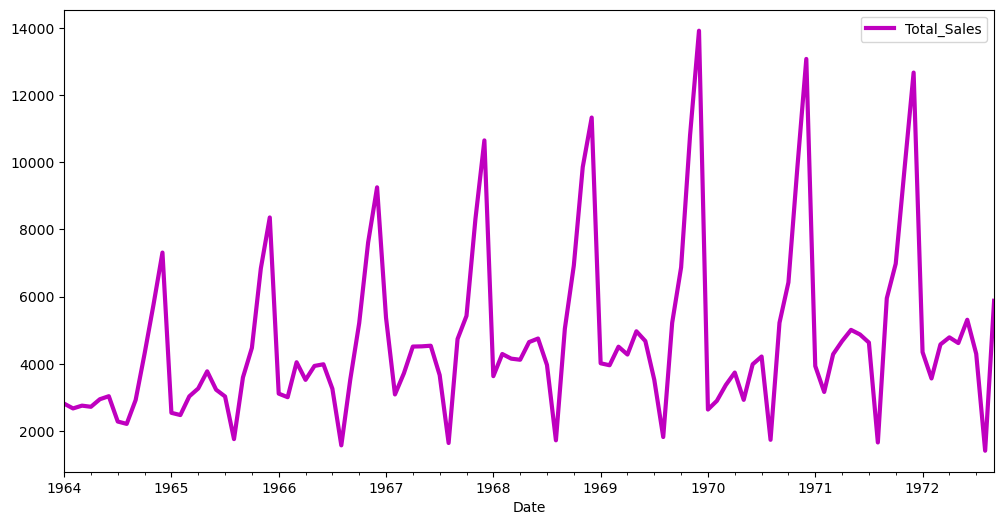

In [9]:
dataset.plot(c = 'm', linewidth=3, figsize=(12,6))

# Data Preprocessing

Check Missing Value of the dataset

In [10]:
dataset.isnull().sum()

Total_Sales    0
dtype: int64

In [11]:
# Remove Null Value
# dataset = dataset.ffill() #interpolate()

Rolling/Moving Average for testing Stationary

Text(0, 0.5, 'Sales')

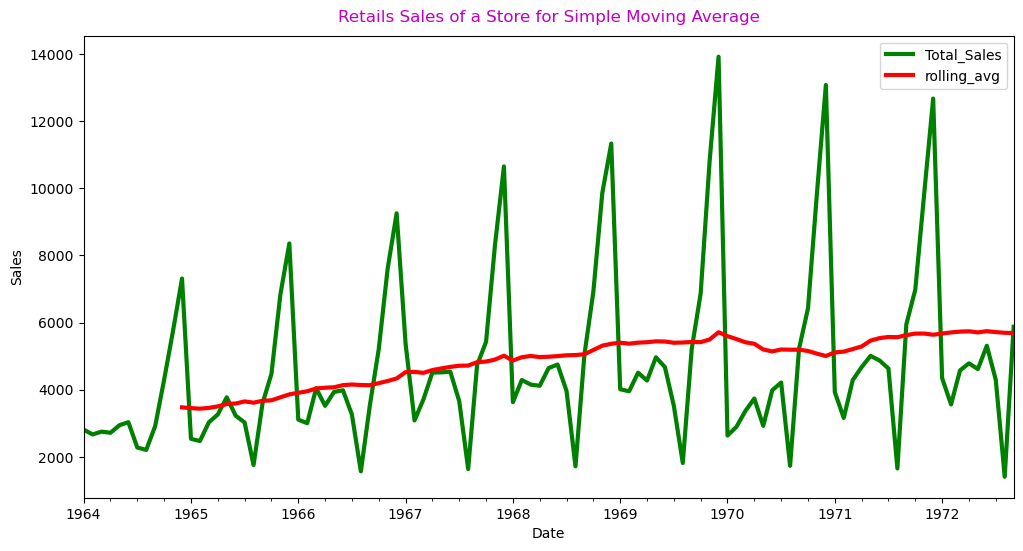

In [12]:
dataset['rolling_avg'] = dataset.Total_Sales.rolling(12).mean()
colors = ['g', 'r']
dataset[["Total_Sales", "rolling_avg"]].plot(color=colors, linewidth=3, figsize=(12,6))
plt.title("Retails Sales of a Store for Simple Moving Average", pad = 10, c = 'm')
plt.xlabel('Date')
plt.ylabel('Sales')


Dickey Fuller Test for testing Stationary

In [13]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

        
adfuller_test(dataset['Total_Sales'])

ADF Test Statistic : -1.8335930563276297
p-value : 0.3639157716602417
#Lags Used : 11
Number of Observations Used : 93
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


Differencing for getting Stationary

In [14]:
dataset['Sales First Difference']=dataset['Total_Sales']-dataset['Total_Sales'].shift(1)

dataset['Seasonal First Difference']=dataset['Total_Sales']-dataset['Total_Sales'].shift(12)
dataset.head(15)

,Total_Sales,rolling_avg,Sales First Difference,Seasonal First Difference
Date,,,,
1964-01-01,2815,NaN,NaN,NaN
1964-02-01,2672,NaN,-143.0,NaN
1964-03-01,2755,NaN,83.0,NaN
1964-04-01,2721,NaN,-34.0,NaN
1964-05-01,2946,NaN,225.0,NaN
1964-06-01,3036,NaN,90.0,NaN
1964-07-01,2282,NaN,-754.0,NaN
1964-08-01,2212,NaN,-70.0,NaN
1964-09-01,2922,NaN,710.0,NaN


In [15]:
adfuller_test(dataset['Seasonal First Difference'].dropna())

ADF Test Statistic : -7.626619157213163
p-value : 2.060579696813685e-11
#Lags Used : 0
Number of Observations Used : 92
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


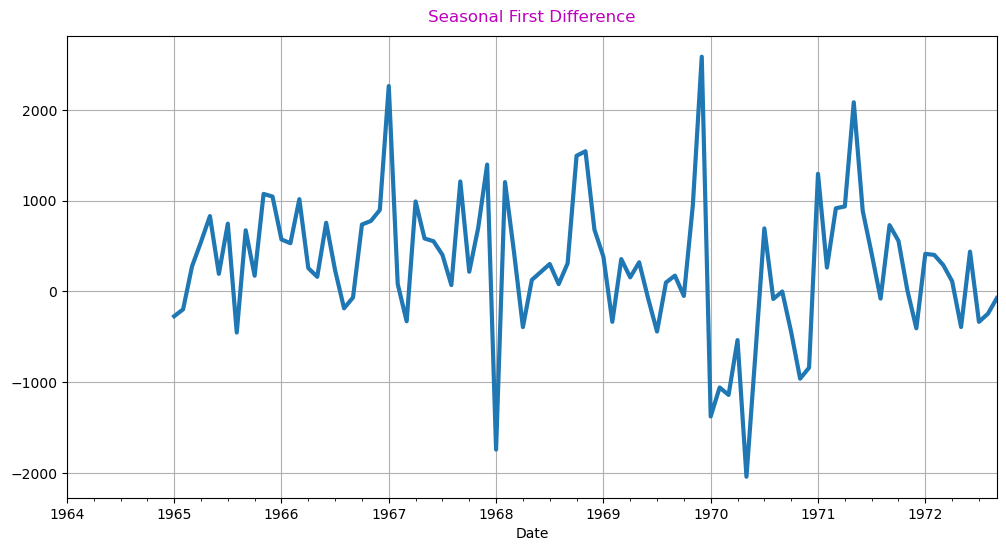

In [16]:
dataset["Seasonal First Difference"].plot(linewidth=3, figsize=(12,6))
plt.title("Seasonal First Difference", pad = 10, c = 'm')
plt.grid()

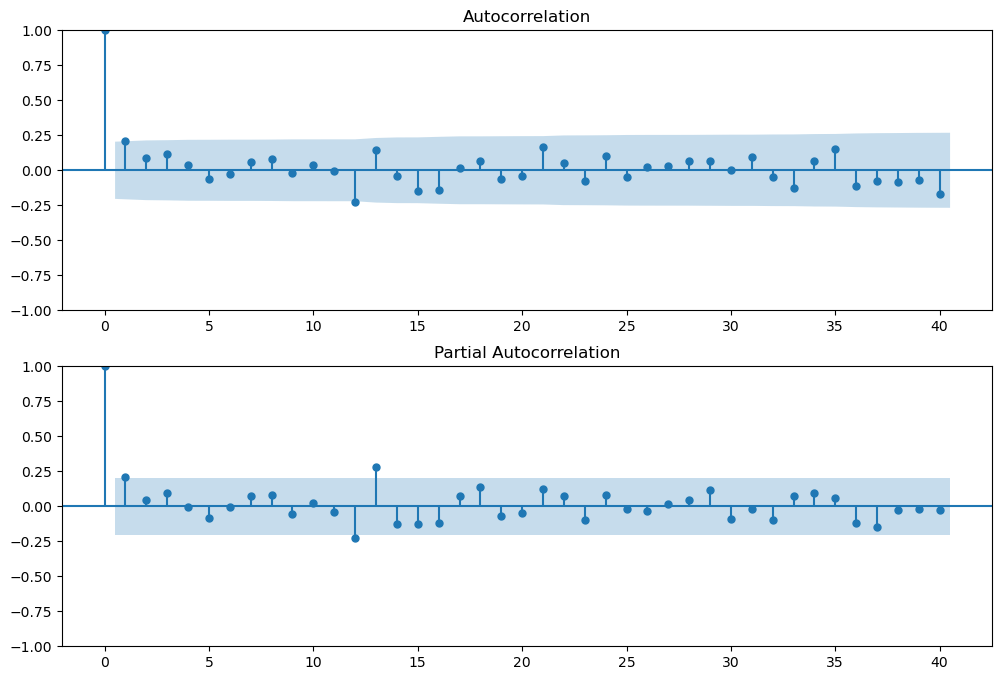

In [17]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,1,1)
fig = plot_acf(dataset['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(2,1,2)
fig = plot_pacf(dataset['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

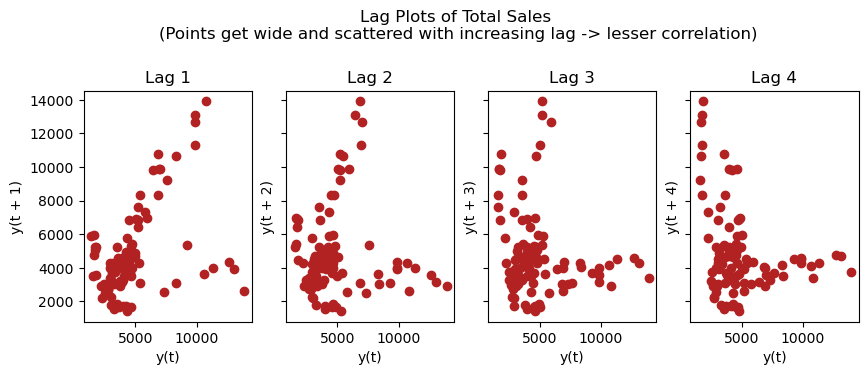

In [18]:
from pandas.plotting import lag_plot
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(dataset.Total_Sales, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Total Sales \n(Points get wide and scattered with increasing lag -> lesser correlation)\n', y=1.15)      
plt.show();

"Grid Search" to find the optimal set of parameters.

In [19]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
aic = []
params = []
param_seasonals = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(dataset["Seasonal First Difference"],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            params.append(param)
            aic.append(results.aic)
            param_seasonals.append(param_seasonal)
        except:
            continue
            
print("\n\nOptimal Set of Parameters based on AIC: ")          
min_values_index_aic = np.argmin(aic)
print('SARIMA{}x{} - AIC:{}'.format(params[min_values_index_aic], param_seasonals[min_values_index_aic], aic[min_values_index_aic]))

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1511.2713844170698
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1497.4352397678579
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1575.261238249959
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1317.1692257539469
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1512.6366920013731
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1499.2551126445428
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1349.3150462276506
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1315.1974743765609
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1505.458970282013
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1474.4403691246064
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1559.0691094630706
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1300.1430544893065
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1503.873328742843
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1475.086541859423
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1346.0030792811835
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1295.6356402566244
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1542.8688000304508
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - A

In [20]:
training_size = int(len(dataset)*0.9)
train_data, test_data = dataset[0:training_size],dataset[training_size:len(dataset)] 

# Model Selection & Training

SARIMA Model

In [21]:
model=sm.tsa.statespace.SARIMAX(train_data['Total_Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

In [22]:
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2996      0.089      3.351      0.001       0.124       0.475
ma.L1         -0.9470      0.049    -19.450      0.000      -1.042      -0.852
ar.S.L12      -0.6150      0.265     -2.322      0.020      -1.134      -0.096
ma.S.L12       0.3703      0.277      1.336      0.181      -0.173       0.913
sigma2      5.329e+05   6.97e+04      7.642      0.000    3.96e+05     6.7e+05


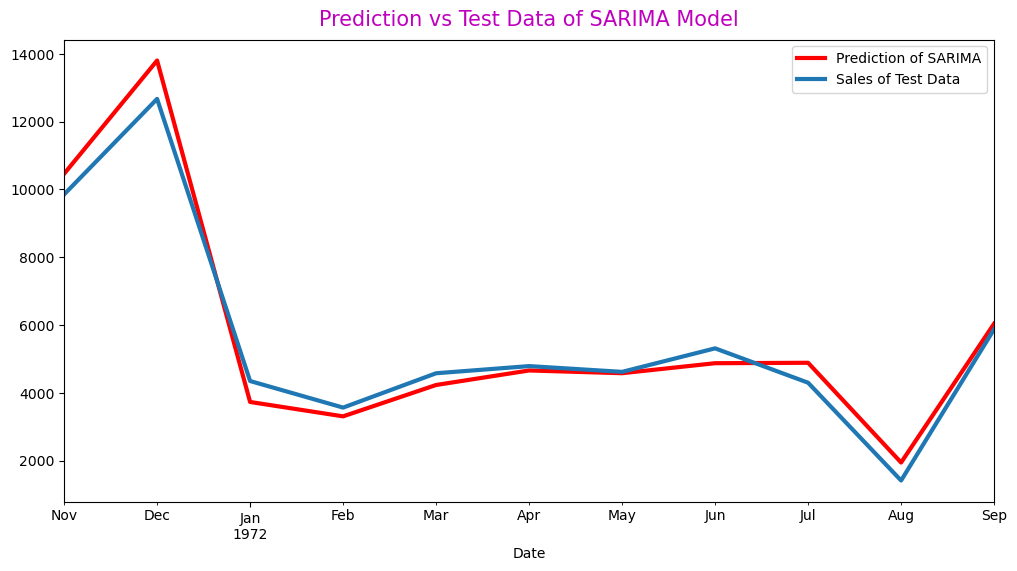

In [23]:
prediction_SARIMA = results.predict(start=len(train_data),end=len(train_data)+len(test_data)-1,dynamic=True)
plt.figure(figsize=(12,6))
prediction_SARIMA.plot(linewidth=3,label = "Prediction of SARIMA", c = 'r')
test_data['Total_Sales'].plot(linewidth=3, label = "Sales of Test Data")
plt.title('Prediction vs Test Data of SARIMA Model', color = 'm', size = 15, pad = 10)
plt.legend()

# Model Evaluation

In [24]:
print("Mean of Test Data: ", test_data["Total_Sales"].mean())
root_mean_square_error_SARIMA = np.sqrt(mean_squared_error(test_data["Total_Sales"], prediction_SARIMA))
print("Mean Suare Error of SARIMA Model : ", round(root_mean_square_error_SARIMA,2))

Mean of Test Data:  5574.181818181818
Mean Suare Error of SARIMA Model :  529.56


# Future Sales Prediction

In [88]:
from pandas.tseries.offsets import DateOffset
future_dates=[dataset.index[-1]+ DateOffset(months=x)for x in range(0,24)]
future_dates

[Timestamp('1972-09-01 00:00:00'),
 Timestamp('1972-10-01 00:00:00'),
 Timestamp('1972-11-01 00:00:00'),
 Timestamp('1972-12-01 00:00:00'),
 Timestamp('1973-01-01 00:00:00'),
 Timestamp('1973-02-01 00:00:00'),
 Timestamp('1973-03-01 00:00:00'),
 Timestamp('1973-04-01 00:00:00'),
 Timestamp('1973-05-01 00:00:00'),
 Timestamp('1973-06-01 00:00:00'),
 Timestamp('1973-07-01 00:00:00'),
 Timestamp('1973-08-01 00:00:00'),
 Timestamp('1973-09-01 00:00:00'),
 Timestamp('1973-10-01 00:00:00'),
 Timestamp('1973-11-01 00:00:00'),
 Timestamp('1973-12-01 00:00:00'),
 Timestamp('1974-01-01 00:00:00'),
 Timestamp('1974-02-01 00:00:00'),
 Timestamp('1974-03-01 00:00:00'),
 Timestamp('1974-04-01 00:00:00'),
 Timestamp('1974-05-01 00:00:00'),
 Timestamp('1974-06-01 00:00:00'),
 Timestamp('1974-07-01 00:00:00'),
 Timestamp('1974-08-01 00:00:00')]

In [89]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=dataset.columns)
future_datest_df.tail()

,Total_Sales,rolling_avg,Sales First Difference,Seasonal First Difference
1974-04-01,NaN,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN,NaN
1974-06-01,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN
1974-08-01,NaN,NaN,NaN,NaN


In [90]:
future_df=pd.concat([dataset,future_datest_df])
future_df

,Total_Sales,rolling_avg,Sales First Difference,Seasonal First Difference
1964-01-01,2815,NaN,NaN,NaN
1964-02-01,2672,NaN,-143.0,NaN
1964-03-01,2755,NaN,83.0,NaN
1964-04-01,2721,NaN,-34.0,NaN
1964-05-01,2946,NaN,225.0,NaN
...,...,...,...,...
1974-04-01,NaN,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN,NaN
1974-06-01,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN


In [92]:
future_df

,Total_Sales,rolling_avg,Sales First Difference,Seasonal First Difference,forecast
1964-01-01,2815,NaN,NaN,NaN,NaN
1964-02-01,2672,NaN,-143.0,NaN,NaN
1964-03-01,2755,NaN,83.0,NaN,NaN
1964-04-01,2721,NaN,-34.0,NaN,NaN
1964-05-01,2946,NaN,225.0,NaN,NaN
...,...,...,...,...,...
1974-04-01,NaN,NaN,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN,NaN,NaN
1974-06-01,NaN,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN,NaN


<Axes: >

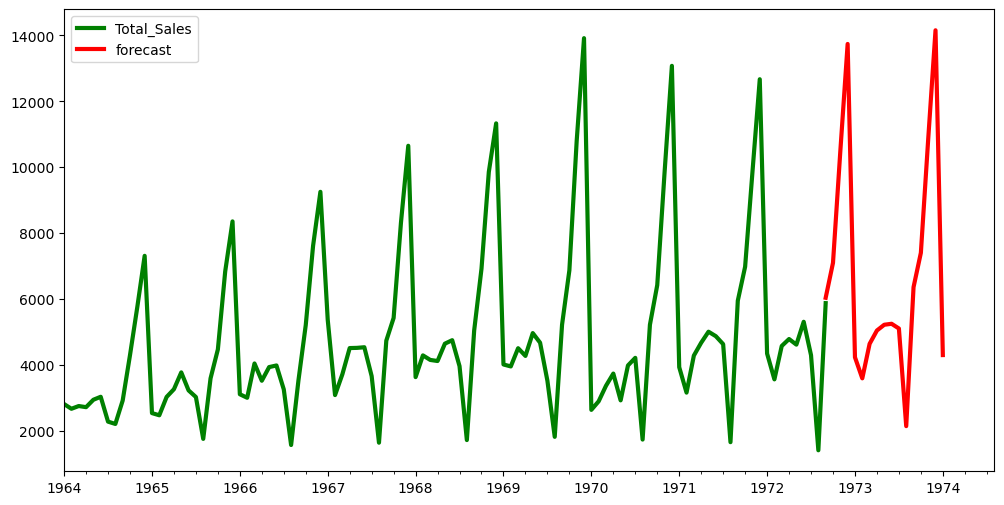

In [91]:
future_df['forecast'] = results.predict(start = len(dataset)-1, end = 120, dynamic= True) 
colors = ['g', 'r']
future_df[['Total_Sales', 'forecast']].plot(color = colors, linewidth=3, figsize=(12,6)) 

# LSTM Model

In [29]:
train_data = train_data.drop(["rolling_avg", "Sales First Difference",  "Seasonal First Difference"], axis = 1)
test_data = test_data.drop(["rolling_avg", "Sales First Difference",  "Seasonal First Difference"], axis = 1)

In [30]:
tf.keras.utils.set_random_seed(1)
# Data Scaling
scaler = MinMaxScaler()

In [31]:
scaler.fit(train_data)
scaled_train = scaler.transform(train_data)
scaled_test = scaler.transform(test_data)

In [32]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size= 1)

In [33]:
#Define Model
model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape = (n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer="adam", loss = 'mse')

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [35]:
#fit model
model.fit(generator, epochs = 600)

Epoch 1/600
82/82 [==============================] - 2s 4ms/step - loss: 0.0482
Epoch 2/600
82/82 [==============================] - 0s 4ms/step - loss: 0.0445
Epoch 3/600
82/82 [==============================] - 0s 4ms/step - loss: 0.0409
Epoch 4/600
82/82 [==============================] - 0s 4ms/step - loss: 0.0356
Epoch 5/600
82/82 [==============================] - 0s 4ms/step - loss: 0.0319
Epoch 6/600
82/82 [==============================] - 0s 4ms/step - loss: 0.0409
Epoch 7/600
82/82 [==============================] - 0s 4ms/step - loss: 0.0265
Epoch 8/600
82/82 [==============================] - 0s 4ms/step - loss: 0.0235
Epoch 9/600
82/82 [==============================] - 0s 4ms/step - loss: 0.0157
Epoch 10/600
82/82 [==============================] - 0s 4ms/step - loss: 0.0136
Epoch 11/600
82/82 [==============================] - 0s 4ms/step - loss: 0.0095
Epoch 12/600
82/82 [==============================] - 0s 4ms/step - loss: 0.0097
Epoch 13/600
82/82 [=================

82/82 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 103/600
82/82 [==============================] - 0s 5ms/step - loss: 0.0033
Epoch 104/600
82/82 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 105/600
82/82 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 106/600
82/82 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 107/600
82/82 [==============================] - 0s 4ms/step - loss: 0.0019
Epoch 108/600
82/82 [==============================] - 0s 4ms/step - loss: 0.0027
Epoch 109/600
82/82 [==============================] - 0s 4ms/step - loss: 0.0029
Epoch 110/600
82/82 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 111/600
82/82 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 112/600
82/82 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 113/600
82/82 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 114/600
82/82 [=========

82/82 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 203/600
82/82 [==============================] - 1s 6ms/step - loss: 0.0017
Epoch 204/600
82/82 [==============================] - 1s 7ms/step - loss: 0.0016
Epoch 205/600
82/82 [==============================] - 1s 8ms/step - loss: 0.0021
Epoch 206/600
82/82 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 207/600
82/82 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 208/600
82/82 [==============================] - 1s 9ms/step - loss: 0.0013
Epoch 209/600
82/82 [==============================] - 1s 7ms/step - loss: 0.0013
Epoch 210/600
82/82 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 211/600
82/82 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 212/600
82/82 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 213/600
82/82 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 214/600
82/82 [=========

82/82 [==============================] - 0s 5ms/step - loss: 8.5490e-04
Epoch 300/600
82/82 [==============================] - 0s 4ms/step - loss: 8.8259e-04
Epoch 301/600
82/82 [==============================] - 0s 4ms/step - loss: 8.0991e-04
Epoch 302/600
82/82 [==============================] - 0s 4ms/step - loss: 6.3635e-04
Epoch 303/600
82/82 [==============================] - 0s 5ms/step - loss: 8.9381e-04
Epoch 304/600
82/82 [==============================] - 0s 5ms/step - loss: 8.6451e-04
Epoch 305/600
82/82 [==============================] - 1s 7ms/step - loss: 0.0013
Epoch 306/600
82/82 [==============================] - 1s 9ms/step - loss: 7.3772e-04
Epoch 307/600
82/82 [==============================] - 1s 9ms/step - loss: 7.9326e-04
Epoch 308/600
82/82 [==============================] - 0s 6ms/step - loss: 6.7673e-04
Epoch 309/600
82/82 [==============================] - 0s 5ms/step - loss: 8.5274e-04
Epoch 310/600
82/82 [==============================] - 0s 6ms/step - los

82/82 [==============================] - 0s 4ms/step - loss: 6.9684e-04
Epoch 395/600
82/82 [==============================] - 0s 4ms/step - loss: 3.9905e-04
Epoch 396/600
82/82 [==============================] - 0s 5ms/step - loss: 6.0530e-04
Epoch 397/600
82/82 [==============================] - 0s 5ms/step - loss: 4.3812e-04
Epoch 398/600
82/82 [==============================] - 0s 5ms/step - loss: 5.5212e-04
Epoch 399/600
82/82 [==============================] - 0s 5ms/step - loss: 4.5385e-04
Epoch 400/600
82/82 [==============================] - 0s 4ms/step - loss: 3.1817e-04
Epoch 401/600
82/82 [==============================] - 1s 6ms/step - loss: 3.9433e-04
Epoch 402/600
82/82 [==============================] - 0s 6ms/step - loss: 3.7932e-04
Epoch 403/600
82/82 [==============================] - 0s 5ms/step - loss: 7.4243e-04
Epoch 404/600
82/82 [==============================] - 0s 5ms/step - loss: 4.4466e-04
Epoch 405/600
82/82 [==============================] - 0s 5ms/step -

82/82 [==============================] - 1s 6ms/step - loss: 3.6339e-04
Epoch 490/600
82/82 [==============================] - 1s 6ms/step - loss: 2.4136e-04
Epoch 491/600
82/82 [==============================] - 1s 7ms/step - loss: 1.9279e-04
Epoch 492/600
82/82 [==============================] - 1s 6ms/step - loss: 2.1530e-04
Epoch 493/600
82/82 [==============================] - 1s 6ms/step - loss: 2.3660e-04
Epoch 494/600
82/82 [==============================] - 0s 5ms/step - loss: 2.1857e-04
Epoch 495/600
82/82 [==============================] - 0s 5ms/step - loss: 2.6735e-04
Epoch 496/600
82/82 [==============================] - 0s 5ms/step - loss: 3.6839e-04
Epoch 497/600
82/82 [==============================] - 1s 7ms/step - loss: 3.0660e-04
Epoch 498/600
82/82 [==============================] - 0s 6ms/step - loss: 3.3564e-04
Epoch 499/600
82/82 [==============================] - 1s 7ms/step - loss: 1.3074e-04
Epoch 500/600
82/82 [==============================] - 0s 6ms/step -

82/82 [==============================] - 0s 4ms/step - loss: 5.3024e-04
Epoch 585/600
82/82 [==============================] - 0s 4ms/step - loss: 3.5288e-04
Epoch 586/600
82/82 [==============================] - 0s 4ms/step - loss: 1.3714e-04
Epoch 587/600
82/82 [==============================] - 0s 4ms/step - loss: 1.6628e-04
Epoch 588/600
82/82 [==============================] - 0s 4ms/step - loss: 1.3958e-04
Epoch 589/600
82/82 [==============================] - 0s 4ms/step - loss: 1.3332e-04
Epoch 590/600
82/82 [==============================] - 0s 5ms/step - loss: 1.0425e-04
Epoch 591/600
82/82 [==============================] - 0s 4ms/step - loss: 8.3251e-05
Epoch 592/600
82/82 [==============================] - 0s 4ms/step - loss: 7.7101e-05
Epoch 593/600
82/82 [==============================] - 0s 4ms/step - loss: 7.9873e-05
Epoch 594/600
82/82 [==============================] - 0s 4ms/step - loss: 7.0732e-05
Epoch 595/600
82/82 [==============================] - 0s 4ms/step -

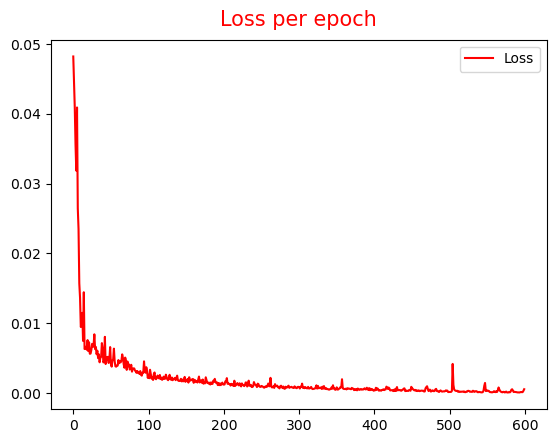

In [36]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch, c = "r", label = "Loss")
plt.title('Loss per epoch', color = 'red', size = 15, pad = 10)
plt.legend()
     

In [37]:
last_train_batch = scaled_train[-n_input:]

In [38]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))
last_train_batch

array([[[0.66993438],
        [0.93194523],
        [0.19128251],
        [0.12873694],
        [0.2198007 ],
        [0.25139755],
        [0.27845743],
        [0.26743903],
        [0.2479138 ],
        [0.00696751],
        [0.35469497],
        [0.43814308]]])

In [39]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 207ms/step


array([[0.69411063]], dtype=float32)

In [40]:
scaled_test.shape

(11, 1)

In [41]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, -n_input, n_features))
for i in range(len(test_data)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)

1/1 [==============================] - 0s 23ms/step


In [42]:
predictions_LSTM = scaler.inverse_transform(test_predictions)

In [43]:
test_data["predictions_LSTM"] = predictions_LSTM

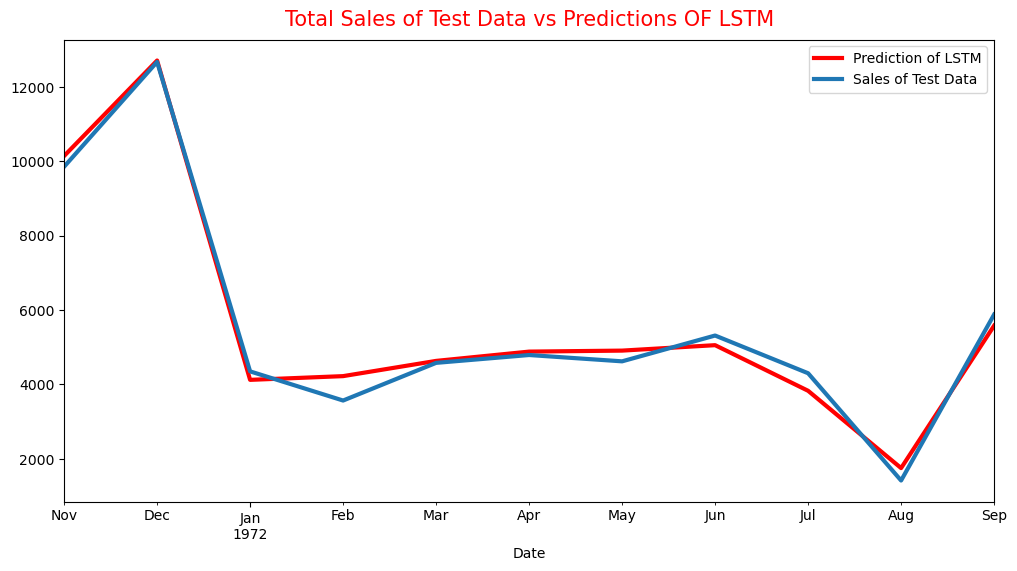

In [44]:
plt.figure(figsize=(12,6))
test_data["predictions_LSTM"].plot(linewidth=3, label = "Prediction of LSTM", c = 'r')
test_data['Total_Sales'].plot(linewidth=3, label = "Sales of Test Data")
plt.title('Total Sales of Test Data vs Predictions OF LSTM', color = 'red', size = 15, pad = 10)
plt.legend()

In [45]:
root_mean_square_error_LSTM = np.sqrt(mean_squared_error(test_data['Total_Sales'], test_data["predictions_LSTM"]))
print("Root Mean Square Error of LSTM Model : ", round(root_mean_square_error_LSTM, 2))

Root Mean Square Error of LSTM Model :  323.89


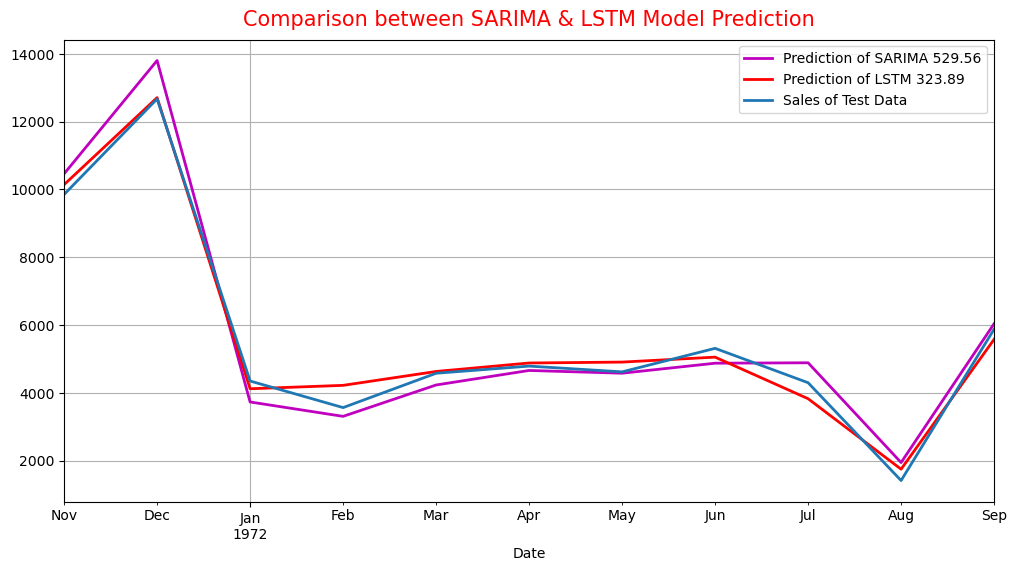

In [46]:
plt.figure(figsize=(12,6))
prediction_SARIMA.plot(linewidth=2, label = f"Prediction of SARIMA {round(root_mean_square_error_SARIMA, 2)}", c = 'm')
test_data["predictions_LSTM"].plot(linewidth=2, label = f"Prediction of LSTM {round(root_mean_square_error_LSTM, 2)}", c = 'r')
test_data['Total_Sales'].plot(linewidth=2, label = "Sales of Test Data")
plt.title('Comparison between SARIMA & LSTM Model Prediction', color = 'red', size = 15, pad = 10)
plt.legend()
plt.grid()

In [74]:
df = dataset.drop(["rolling_avg", "Sales First Difference", "Seasonal First Difference"], axis=1)

In [78]:

norm_df = scaler.fit_transform(df)
future_predictions = []
first_eval_batch = norm_df[-12:]
current_batch = first_eval_batch.reshape((1, 12, 1))
for i in range(12):
    current_pred = model.predict(current_batch)[0]
    future_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)

1/1 [==============================] - 0s 21ms/step


In [79]:
predictions_LSTM_future = scaler.inverse_transform(future_predictions)

#### 